# Import Packages & Libraries

In [24]:
# Standard library imports
from datetime import datetime, timedelta

# Third-party library imports
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports for data preprocessing, model selection, metrics, and models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, 
                             roc_curve, auc, precision_recall_curve, 
                             average_precision_score, make_scorer)

# Set the theme for seaborn for consistent visualization styling
sns.set_theme()


# Data Wrangling

In [ ]:
# Use the earliest start date as per the API documentation
start_date = datetime.strptime('2018-10-11', '%Y-%m-%d')  # Earliest start date available
end_date = datetime.today()  # Today's date as end date
stablecoins = ["USDT", "TUSD", "USDC", "PAX", "DAI", "GUSD", "USDS"]

base_url = "https://stablecoinstats.com/api/range"

data_list = []

# Function to split the date range into intervals of up to 29 days
def date_range(start, end, delta):
    current = start
    while current < end:
        yield current, min(current + delta, end)
        current += delta + timedelta(days=1)

# Iterate over each coin
for coin in stablecoins:
    # Break the date range into intervals of up to 29 days
    for start, stop in date_range(start_date, end_date, timedelta(days=29)):
        start_str = start.strftime('%Y-%m-%d')
        stop_str = stop.strftime('%Y-%m-%d')
        url = f"{base_url}/{start_str}/{stop_str}/{coin}"
        
        try:
            response = requests.get(url)
            response.raise_for_status()  # Ensure we got a '200 OK' response
            
            data = response.json()
            
            # Handle the data according to your needs
            if 'error' not in data:
                # Assuming data is structured with dates as keys and details as values
                for date, details in data.items():
                    if isinstance(details, dict):
                        for symbol, detail in details.items():
                            detail['date'] = date
                            detail['symbol'] = symbol
                            data_list.append(detail)
            else:
                print(f"API error for {coin} from {start_str} to {stop_str}: {data['error']}")
                
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for {coin}: {e}")

# Convert the list to a DataFrame
data_df = pd.DataFrame(data_list)


In [2]:
df = pd.read_csv("stable_full2.csv", index_col=0)

In [3]:
# Step 1: Handling NaN values
df.fillna(0, inplace=True)

# Step 2: Extracting nested data from the 'blockchain' column.
df['active_addresses'] = df['blockchain'].apply(lambda x: x['active_addresses'] if isinstance(x, dict) else 0)
df['tx_count'] = df['blockchain'].apply(lambda x: x['tx_count'] if isinstance(x, dict) else 0)

# Step 3: Converting date strings to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Step 4: Ensure numerical data is in the correct format
numerical_columns = ['circulation', 'erc20_total_tokens', 'erc20_treasury_balance', 'omni_total_tokens', 
                     'omni_treasury_balance', 'quarantined_balance', 'price', 'price_percent_change_24h', 
                     'volume', 'circulation_change_24h', 'circulation_percent_change_24h', 
                     'volume_change_24h', 'volume_percent_change_24h']
for col in numerical_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Drop the original 'blockchain' column as no longer needed
df.drop(columns=['blockchain'], inplace=True)

# Display the processed DataFrame
df.head()


,circulation,erc20_total_tokens,erc20_treasury_balance,name,omni_total_tokens,omni_treasury_balance,quarantined_balance,symbol,date,price,price_percent_change_24h,treasury,volume,circulation_change_24h,circulation_percent_change_24h,volume_change_24h,volume_percent_change_24h,remarks,active_addresses,tx_count
0,2.737372e+09,6.010950e+07,25108983.0,Tether USD,3.020000e+09,2.866788e+08,30950010.0,USDT,2018-10-11,0.000000,0.000000,0,0.000000e+00,0.0,0.0,0.0,0.0,0,0,0
1,2.737372e+09,0.000000e+00,0.0,Tether USD,0.000000e+00,0.000000e+00,0.0,USDT,2018-10-12,0.994102,0.062611,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",2.962383e+09,0.0,0.0,0.0,0.0,0,0,0
2,2.737372e+09,0.000000e+00,0.0,Tether USD,0.000000e+00,0.000000e+00,0.0,USDT,2018-10-13,0.988046,-0.527660,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",3.688741e+08,0.0,0.0,0.0,0.0,0,0,0
3,2.537372e+09,0.000000e+00,0.0,Tether USD,0.000000e+00,0.000000e+00,0.0,USDT,2018-10-14,0.972332,0.021564,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",5.182188e+08,0.0,0.0,0.0,0.0,0,0,0
4,2.537372e+09,0.000000e+00,0.0,Tether USD,0.000000e+00,0.000000e+00,0.0,USDT,2018-10-15,0.955407,-0.921532,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",3.012224e+09,0.0,0.0,0.0,0.0,0,0,0


# Data Pre-processing

In [4]:
# Function to fill with random values within ±2 standard deviations of the mean, for a specific group
def fill_numerical_within_std(group, col):
    # Calculate mean and standard deviation for the group
    mean, std = group[col].mean(), group[col].std()
    # If the column only contains 0s, mean and std would be 0, and filling with random values isn't needed
    if std > 0:
        # Replace 0 values with a random number within ±2 standard deviations of the mean
        group[col] = group[col].apply(lambda x: np.random.normal(loc=mean, scale=std) if x == 0 else x)
    return group

# Preprocess the DataFrame
def preprocess_df(df):
    # Define the columns to process numerically
    financial_columns = ['circulation', 'erc20_total_tokens', 'erc20_treasury_balance',
                         'omni_total_tokens', 'omni_treasury_balance', 'quarantined_balance', 'volume']
    
    # Process financial columns with custom logic
    for col in financial_columns:
        # Group by 'symbol' and apply random filling within ±2 standard deviations
        df = df.groupby('symbol', group_keys=False).apply(lambda group: fill_numerical_within_std(group, col))

    # Define and process percent change columns by filling 0s with the median of each column
    percent_change_columns = ['price_percent_change_24h', 'circulation_percent_change_24h',
                              'volume_percent_change_24h']
    for col in percent_change_columns:
        median_val = df[col].median()
        df[col] = df[col].replace(0, median_val)

    # Fill categorical/descriptive missing values or 0s with a placeholder
    df['remarks'] = df['remarks'].replace(0, 'No Remarks')

    return df

df = preprocess_df(df)

# Display the first few rows of the preprocessed DataFrame to verify the changes
print(df.head())


    circulation  erc20_total_tokens  erc20_treasury_balance        name  \
0  2.737372e+09        6.010950e+07            2.510898e+07  Tether USD   
1  2.737372e+09       -5.702378e+05           -3.510499e+05  Tether USD   
2  2.737372e+09       -1.115000e+06            3.674348e+05  Tether USD   
3  2.537372e+09        1.011809e+06           -6.062823e+05  Tether USD   
4  2.537372e+09       -1.914481e+05           -1.623376e+06  Tether USD   

   omni_total_tokens  omni_treasury_balance  quarantined_balance symbol  \
0       3.020000e+09           2.866788e+08         3.095001e+07   USDT   
1      -8.259159e+07          -9.683012e+06        -1.397994e+04   USDT   
2       5.966271e+07           2.355244e+06        -2.799297e+05   USDT   
3      -5.858395e+07           2.613544e+06         2.900891e+05   USDT   
4      -5.901437e+06          -4.222612e+06         7.326717e+05   USDT   

        date     price  price_percent_change_24h  \
0 2018-10-11  0.000000                 -0.0025

In [5]:
df.head()

,circulation,erc20_total_tokens,erc20_treasury_balance,name,omni_total_tokens,omni_treasury_balance,quarantined_balance,symbol,date,price,price_percent_change_24h,treasury,volume,circulation_change_24h,circulation_percent_change_24h,volume_change_24h,volume_percent_change_24h,remarks,active_addresses,tx_count
0,2.737372e+09,6.010950e+07,2.510898e+07,Tether USD,3.020000e+09,2.866788e+08,3.095001e+07,USDT,2018-10-11,0.000000,-0.002540,0,5.815578e+09,0.0,0.0,0.0,0.0,No Remarks,0,0
1,2.737372e+09,-5.702378e+05,-3.510499e+05,Tether USD,-8.259159e+07,-9.683012e+06,-1.397994e+04,USDT,2018-10-12,0.994102,0.062611,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",2.962383e+09,0.0,0.0,0.0,0.0,No Remarks,0,0
2,2.737372e+09,-1.115000e+06,3.674348e+05,Tether USD,5.966271e+07,2.355244e+06,-2.799297e+05,USDT,2018-10-13,0.988046,-0.527660,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",3.688741e+08,0.0,0.0,0.0,0.0,No Remarks,0,0
3,2.537372e+09,1.011809e+06,-6.062823e+05,Tether USD,-5.858395e+07,2.613544e+06,2.900891e+05,USDT,2018-10-14,0.972332,0.021564,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",5.182188e+08,0.0,0.0,0.0,0.0,No Remarks,0,0
4,2.537372e+09,-1.914481e+05,-1.623376e+06,Tether USD,-5.901437e+06,-4.222612e+06,7.326717e+05,USDT,2018-10-15,0.955407,-0.921532,"{'erc20_balance': 25108983.0, 'erc20_supply': ...",3.012224e+09,0.0,0.0,0.0,0.0,No Remarks,0,0


# Feature Engineering

In [6]:
dict_df = pd.json_normalize(df['treasury'])
df = pd.concat([df.drop(columns=['treasury']), dict_df], axis=1)

In [7]:
# Ensure 'price' and 'volume' are numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

# Group by 'symbol' and then apply rolling window calculations
# This ensures calculations are done per stablecoin

# Moving Averages for price, grouped by symbol
df['price_ma7'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=7).mean())
df['price_ma30'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=30).mean())

# Moving Averages for volume, grouped by symbol
df['volume_ma7'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=7).mean())
df['volume_ma30'] = df.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=30).mean())

# Volatility Indices: Price standard deviation over the dataset (simplified example), grouped by symbol
df['price_std'] = df.groupby('symbol')['price'].transform(lambda x: x.rolling(window=3).std())

# handling missing values by forward filling
df.fillna(method='ffill', inplace=True)

# Normalization (Min-Max scaling)
scaler = MinMaxScaler()
df[['circulation', 'volume']] = scaler.fit_transform(df[['circulation', 'volume']])



# Exploratory Data Analysis

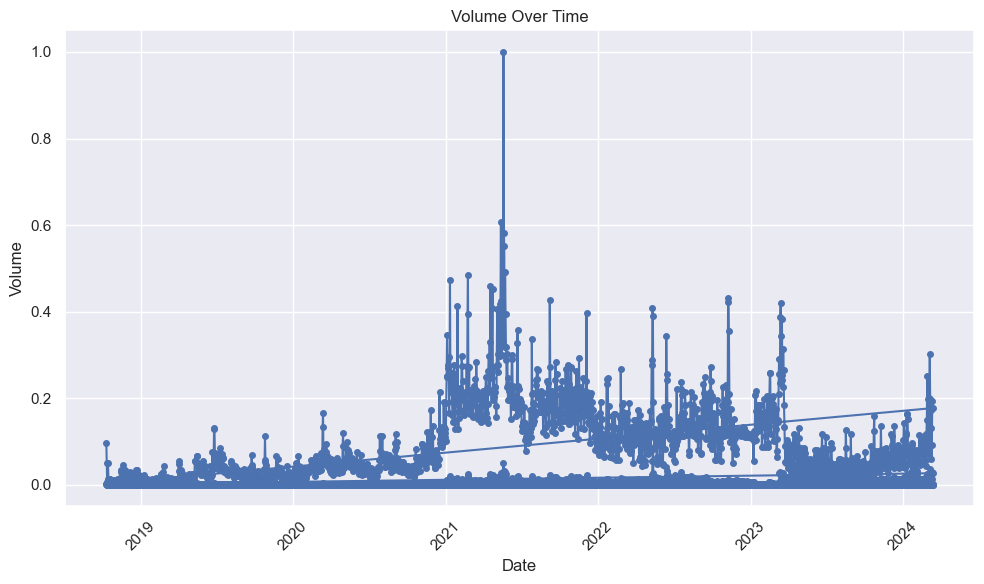

In [8]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])


# Plotting 'volume' over time
plt.figure(figsize=(10, 6))
plt.plot(df.date, df['volume'], marker='o', linestyle='-', markersize=4)
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels

# Show plot
plt.show()


In [9]:
# Select only numeric columns from the DataFrame
numeric_df = df.select_dtypes(include=['number'])

# Drop columns with all NaN values
numeric_df_cleaned = numeric_df.dropna(axis=1, how='all')

# Drop columns with constant value (Standard deviation equals 0)
# This step is necessary because a column with a constant value would lead to NaN entries in the correlation matrix
numeric_df_cleaned = numeric_df_cleaned.loc[:, numeric_df_cleaned.std() > 0]

# Calculate the correlation matrix for the cleaned numeric columns
correlation_matrix = numeric_df_cleaned.corr()

# Display the correlation matrix
print(correlation_matrix)


                                circulation  erc20_total_tokens  \
circulation                        1.000000            0.015602   
erc20_total_tokens                 0.015602            1.000000   
erc20_treasury_balance             0.041123            0.496381   
omni_total_tokens                  0.016590            0.513772   
omni_treasury_balance             -0.007159            0.496221   
quarantined_balance                0.015325            0.499356   
price                             -0.074423           -0.020359   
price_percent_change_24h          -0.009484           -0.000193   
volume                             0.664191            0.013926   
circulation_change_24h             0.144561           -0.011035   
circulation_percent_change_24h    -0.016105           -0.001076   
volume_change_24h                 -0.000074           -0.018269   
volume_percent_change_24h         -0.004528           -0.000072   
price_ma7                         -0.077375            0.00009

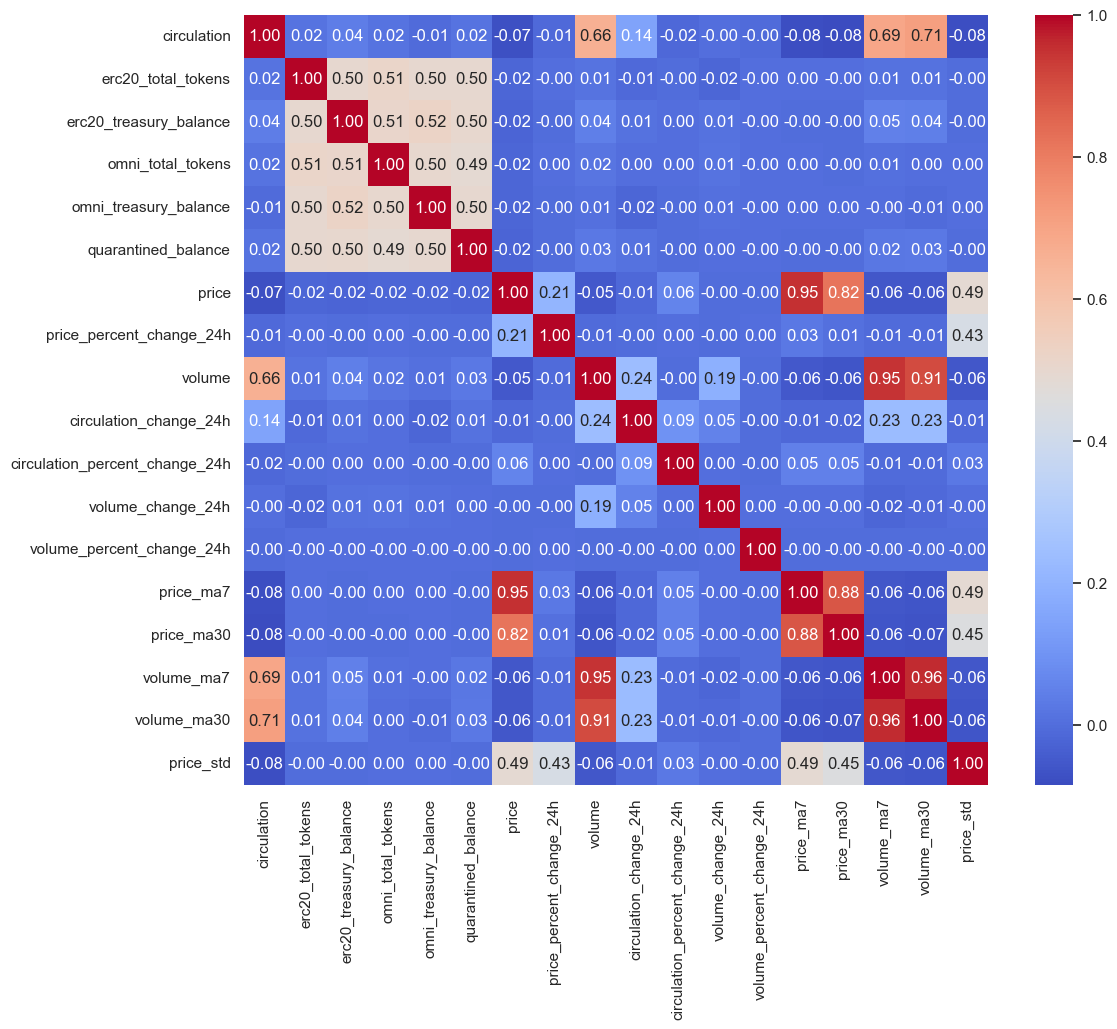

In [10]:
# display correlation matrix
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.show()


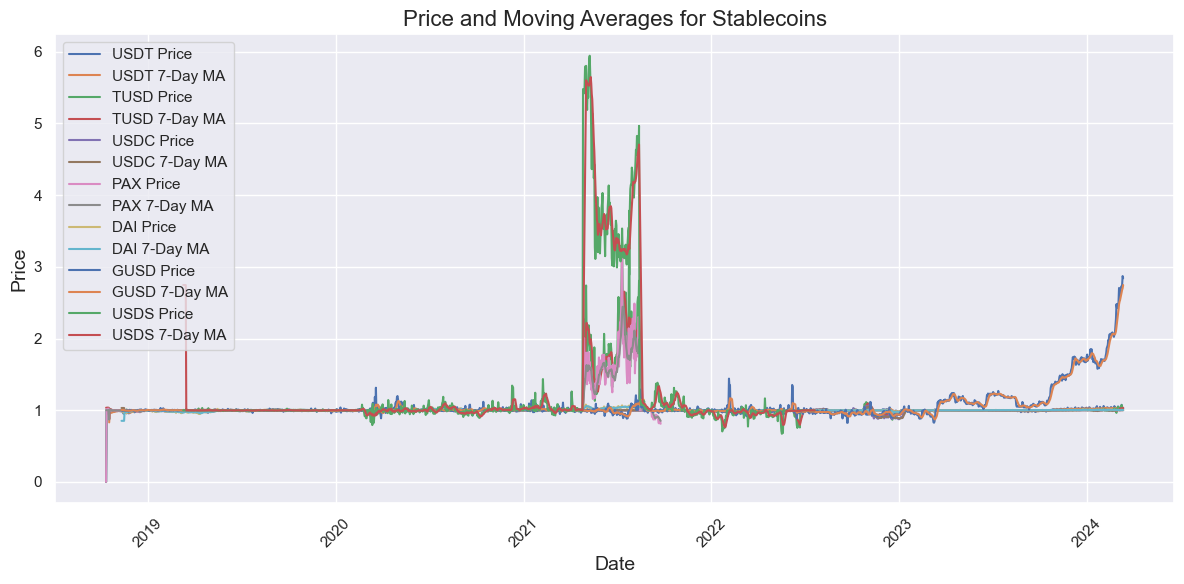

In [11]:
# Plotting with seaborn
plt.figure(figsize=(12, 6))

# Plotting each symbol with seaborn lineplot
for symbol in df['symbol'].unique():
    subset = df[df['symbol'] == symbol]
    sns.lineplot(x='date', y='price', data=subset, label=f"{symbol} Price")
    sns.lineplot(x='date', y='price_ma7', data=subset, label=f"{symbol} 7-Day MA")

plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Price and Moving Averages for Stablecoins', fontsize=16)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/0b/8w8fn7qx0g1dpgh3hfn8msr40000gn/T/ipykernel_24299/1928118349.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date'])


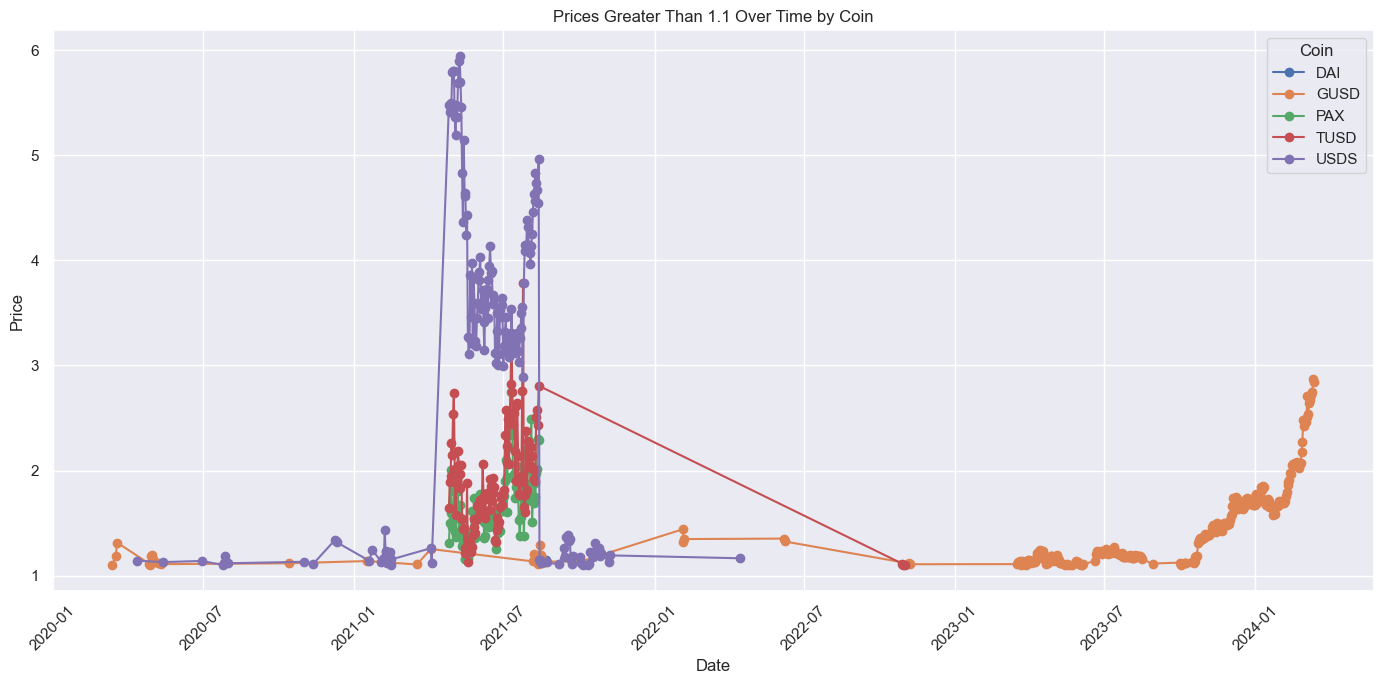

In [12]:
# Filter rows where 'price' is greater than 2
df_filtered = df[df["price"] > 1.1]

# Ensure 'date' is a datetime type for proper plotting
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Sorting values to ensure the dates are in order
df_filtered = df_filtered.sort_values(by='date')

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Group by 'symbol' and plot each group
for symbol, group in df_filtered.groupby('symbol'):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-', label=symbol)

ax.set_title('Prices Greater Than 1.1 Over Time by Coin')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(title='Coin')

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels
plt.show()


/var/folders/0b/8w8fn7qx0g1dpgh3hfn8msr40000gn/T/ipykernel_24299/1955664604.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = pd.to_datetime(df_filtered['date'])


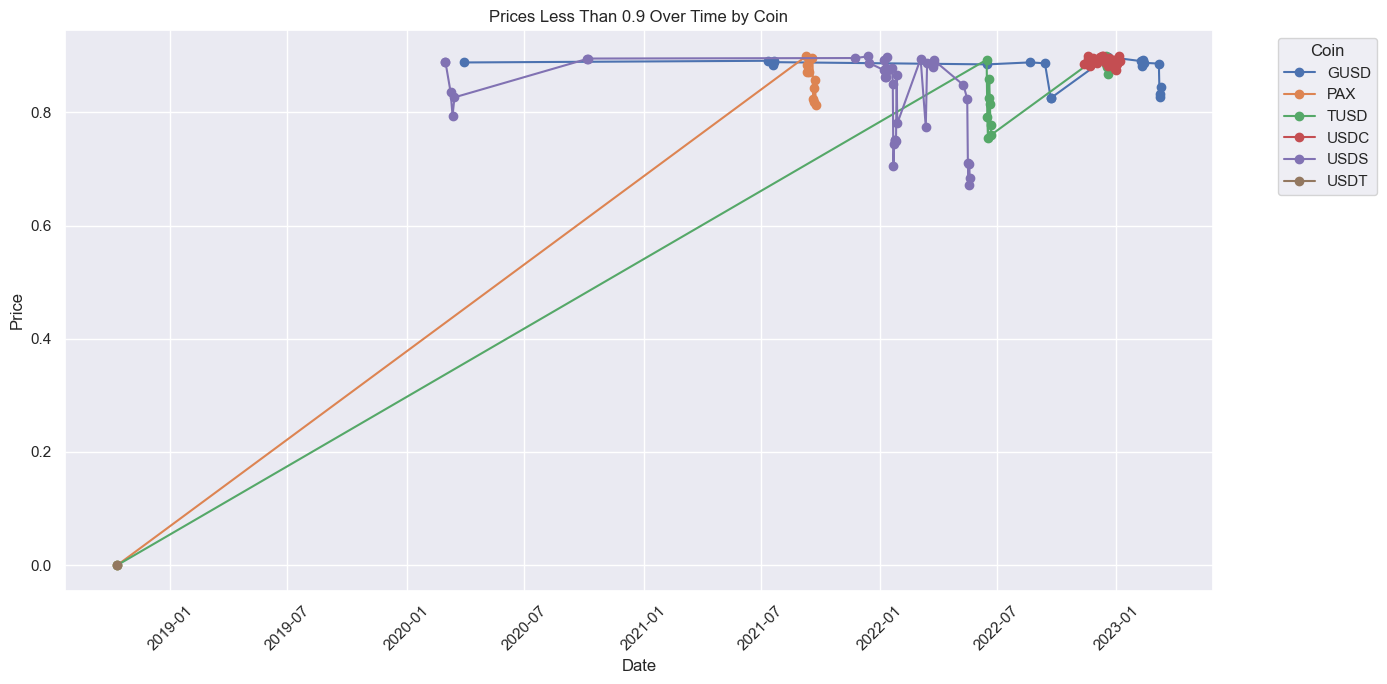

In [13]:
# Filter rows where 'price' is less than 0.9
df_filtered = df[df["price"] < 0.9]

# Ensure 'date' is a datetime type for proper plotting
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Sorting values to ensure the dates are in order
df_filtered = df_filtered.sort_values(by='date')

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Group by 'symbol' and plot each group
for symbol, group in df_filtered.groupby('symbol'):
    ax.plot(group['date'], group['price'], marker='o', linestyle='-', label=symbol)

ax.set_title('Prices Less Than 0.9 Over Time by Coin')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(title='Coin', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Adjust layout to make room for the rotated date labels and legend
plt.show()


# OneClass SVM

In [15]:
df_enhanced = df

features = df_enhanced[['price', 'price_percent_change_24h', 'volume', 'volume_change_24h', 'volume_percent_change_24h', "erc20_total_tokens"]]
scaled_features = scaler.fit_transform(features)

# Model Initialization with Hyperparameter Tuning
model_enhanced = OneClassSVM(kernel="rbf", gamma='auto')
parameters = {'nu': [0.01, 0.05, 0.1]}

# Splitting data into training and testing sets for evaluation purposes
X_train, X_test = train_test_split(scaled_features, test_size=0.3, random_state=42)

# Reverse scaling to get original price values for the test dataset
original_prices_test = scaler.inverse_transform(X_test)[:, 0]  # Assuming 'price' is the first feature

# Generate true labels for the test set based on the price being within 1 ± 0.10
true_labels_test = np.where((original_prices_test >= 0.98) & (original_prices_test <= 1.02), 0, 1)


# Hyperparameters to tune
nu_values = [0.01, 0.05, 0.1]
gamma_values = ['scale', 'auto']

# Placeholder for the best model and its score
best_model = None
best_score = 0
best_params = {'nu': None, 'gamma': None}

# Iterate over all combinations of nu and gamma values
for nu in nu_values:
    for gamma in gamma_values:
        # Initialize OneClassSVM with current parameters
        model = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
        model.fit(X_train)  # Fit model to training data
        
        # Predict on the test set and evaluate
        predictions = model.predict(X_test)
        mapped_predictions = np.where(predictions == -1, 1, 0)  # Map predictions to match true_labels_test
        
        # Evaluate predictions using F1-score
        report = classification_report(true_labels_test, mapped_predictions, target_names=['Normal', 'Anomaly'], output_dict=True)
        score = report['Anomaly']['f1-score']  # Example: focusing on F1-score for 'Anomaly'
        
        # Update best model if current model has a better score
        if score > best_score:
            best_score = score
            best_model = model
            best_params = {'nu': nu, 'gamma': gamma}

# Print best model's parameters and its score
print("Best Hyperparameters:", best_params)
print("Best F1-score:", best_score)

# Reinitialize the OneClassSVM model with the best hyperparameters
best_model_final = OneClassSVM(kernel="rbf", nu=best_params['nu'], gamma=best_params['gamma'])

# Fit the model on the full dataset
best_model_final.fit(scaled_features)

# The model is now trained on the full dataset with the best hyperparameters
# Predicting anomalies on the test set
predictions_enhanced = best_model_final.predict(X_test)
anomalies_enhanced = X_test[predictions_enhanced == -1]


Best Hyperparameters: {'nu': 0.1, 'gamma': 'auto'}
Best F1-score: 0.449952335557674


In [16]:
# Reverse scaling to get original price values for label simulation on your evaluation dataset
original_prices_eval = scaler.inverse_transform(X_test)[:, 0]  # Assuming 'price' is the first feature

# Generate true labels based on the criteria (price being within 1 ± 0.10)
true_labels_eval = np.where((original_prices_eval >= 0.98) & (original_prices_eval <= 1.02), 0, 1)

# Use the retrained best model to predict anomalies on the evaluation dataset
predictions_eval = best_model_final.predict(X_test)
# Map the predictions (-1 for anomalies to 1, and 1 for normal to 0) to match your true labels
mapped_predictions_eval = np.where(predictions_eval == -1, 1, 0)

# Calculate and print the classification report for the evaluation dataset
report_eval = classification_report(true_labels_eval, mapped_predictions_eval, target_names=['Normal', 'Anomaly'])
print(report_eval)


              precision    recall  f1-score   support

      Normal       0.86      0.96      0.91      2942
     Anomaly       0.66      0.34      0.45       694

    accuracy                           0.84      3636
   macro avg       0.76      0.65      0.68      3636
weighted avg       0.82      0.84      0.82      3636



Unique values in true_labels_test: [0 1]
Unique values in predictions_enhanced: [-1  1]
Unique values in mapped_predictions_enhanced: [0 1]


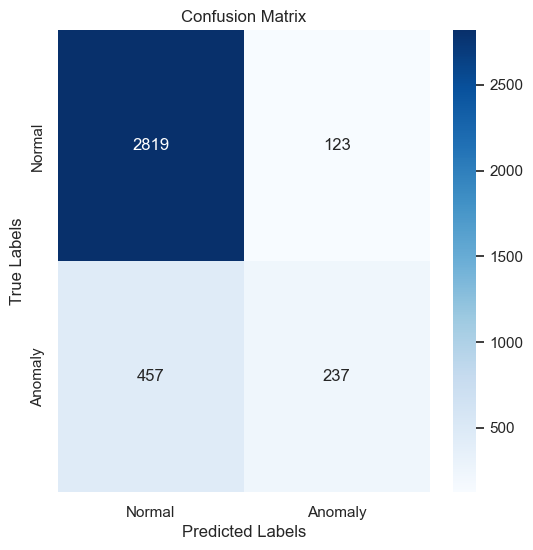

In [17]:
# Correctly mapping the predictions to binary (if not already done so)
mapped_predictions_enhanced = np.where(predictions_enhanced == -1, 1, 0)  # Mapping -1 to 1 and 1 to 0

# Checking unique values in the true labels and predictions
print("Unique values in true_labels_test:", np.unique(true_labels_test))
print("Unique values in predictions_enhanced:", np.unique(predictions_enhanced))
print("Unique values in mapped_predictions_enhanced:", np.unique(mapped_predictions_enhanced))

# Reverse scaling for visualization purposes
original_features = scaler.inverse_transform(X_test)
original_prices = original_features[:, 0]  # Assuming 'price' is the first feature
original_volumes = original_features[:, 1]  # Assuming 'volume' is the second feature for demonstration

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(true_labels_test, mapped_predictions_enhanced)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


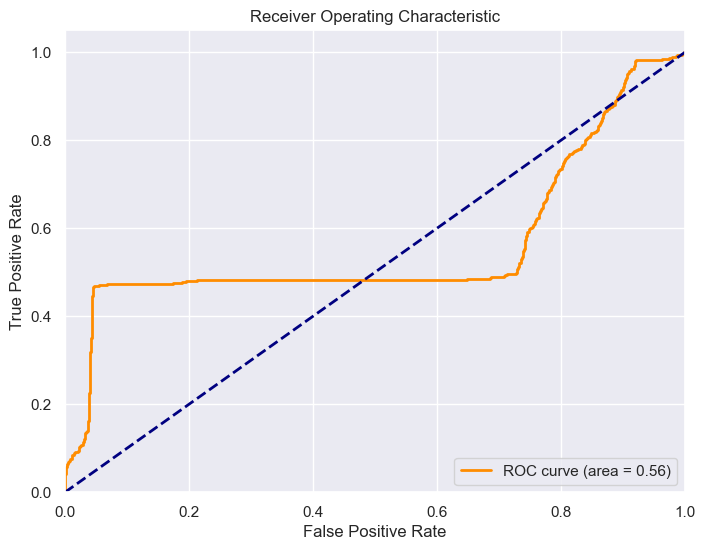

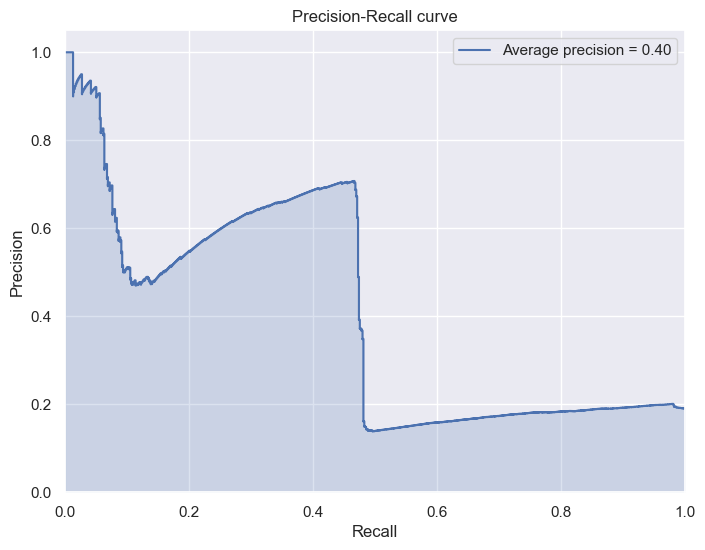

In [18]:
# Get anomaly scores using the decision function
anomaly_scores = best_model_final.decision_function(X_test)

# Invert scores for ROC and Precision-Recall curves
# In OneClassSVM, lower scores indicate more of an anomaly
inverted_scores = -anomaly_scores

# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels_test, inverted_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall Curve and AUC
precision, recall, _ = precision_recall_curve(true_labels_test, inverted_scores)
average_precision = average_precision_score(true_labels_test, inverted_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, color='b', where='post', label=f'Average precision = {average_precision:.2f}')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()


# Isolation Forest

In [40]:
scaled_features = scaler.transform(features)
original_prices = scaler.inverse_transform(scaled_features)[:, 0]  # Adjust index if 'price' is not the first feature

# Simulate labels for the entire dataset based on the condition
y_simulated = np.where((original_prices >= 0.98) & (original_prices <= 1.02), 0, 1)

param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees in the forest
    'max_samples': ['auto', 0.5, 0.75],  # Number of samples to draw from X to train each base estimator
    'contamination': [0.01, 0.05, 0.1],  # The proportion of outliers in the data set
    'bootstrap': [True, False]  # Trying with and without bootstrap

}

# Now, split your dataset into training and testing sets using the simulated labels
X_train, X_test, y_train_simulated, y_test_simulated = train_test_split(
    scaled_features, y_simulated, test_size=0.3, random_state=42
)

# Adjust the custom_scorer to work with the simulated labels
def custom_scorer(y_true, y_pred):
    y_pred = np.where(y_pred == -1, 0, 1)  # Flip labels because Isolation Forest uses -1 for anomalies which we map to 1
    return f1_score(y_true, y_pred)

# Initialize the model
iso_forest = IsolationForest(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=iso_forest, param_grid=param_grid, scoring=make_scorer(custom_scorer, greater_is_better=True), cv=5)

grid_search.fit(X_train, y_train_simulated)

# After finding the best parameters, evaluate on X_test and y_test_simulated
best_model = grid_search.best_estimator_
predictions_test = best_model.predict(X_test)
mapped_predictions_test = np.where(predictions_test == -1, 1, 0)  # Aligning with your labeling scheme



In [41]:
cm = confusion_matrix(y_test_simulated, mapped_predictions_test)

# Initializing all components of the confusion matrix to 0
tn = fp = fn = tp = 0

# Adjusting for different shapes of the confusion matrix based on the predictions and actual labels
if cm.shape == (1, 1):
    # If only one class is present in y_test_simulated, and it is the negative class (normal)
    tn = cm[0, 0]
elif cm.shape == (2, 2):
    # If both classes are present and predictions made for both
    tn, fp, fn, tp = cm.ravel()
else:
    # Handle other unexpected shapes if necessary
    print("Unexpected confusion matrix shape:", cm.shape)

print(f"True Negatives (Correctly identified as Normal): {tn}")
print(f"False Positives (Normal instances incorrectly flagged as Anomalies): {fp}")
print(f"False Negatives (Anomalies incorrectly flagged as Normal): {fn}")
print(f"True Positives (Correctly identified as Anomalies): {tp}")

# Calculating precision, recall, and F1 score where applicable
precision = tp / (tp + fp) if (tp + fp) > 0 else 'Undefined'
recall = tp / (tp + fn) if (tp + fn) > 0 else 'Undefined'
f1 = 2 * (precision * recall) / (precision + recall) if (precision != 'Undefined' and recall != 'Undefined' and (precision + recall) > 0) else 'Undefined'

print(f"Precision (of Anomaly detection): {precision}")
print(f"Recall (of Anomaly detection): {recall}")
print(f"F1 Score (of Anomaly detection): {f1}")


True Negatives (Correctly identified as Normal): 2919
False Positives (Normal instances incorrectly flagged as Anomalies): 23
False Negatives (Anomalies incorrectly flagged as Normal): 687
True Positives (Correctly identified as Anomalies): 7
Precision (of Anomaly detection): 0.23333333333333334
Recall (of Anomaly detection): 0.010086455331412104
F1 Score (of Anomaly detection): 0.019337016574585635


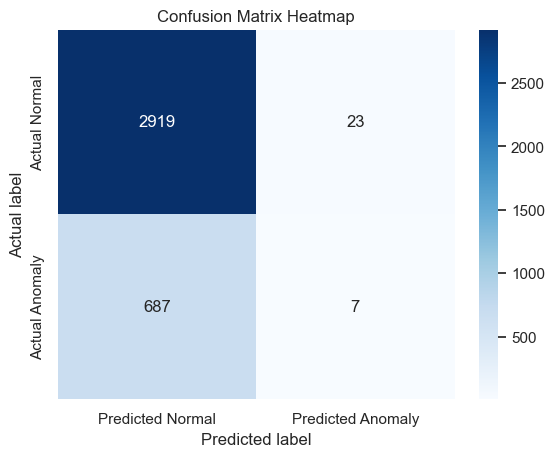

In [42]:
# tn, fp, fn, tp are defined and represent true negatives, false positives, false negatives, and true positives respectively
conf_matrix = [[tn, fp], [fn, tp]]

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.title('Confusion Matrix Heatmap')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


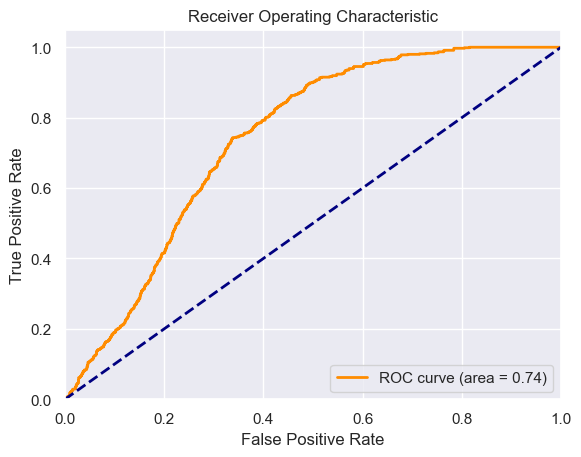

In [43]:
# Use the decision_function to obtain anomaly scores
# Note: Higher scores indicate more normal, lower scores indicate more anomalous
anomaly_scores = best_model.decision_function(X_test)

prediction_scores = -anomaly_scores  # Inverting scores; now lower scores (more anomalous) have higher "probabilities"

# Continuing with ROC curve plotting
fpr, tpr, thresholds = roc_curve(y_test_simulated, prediction_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


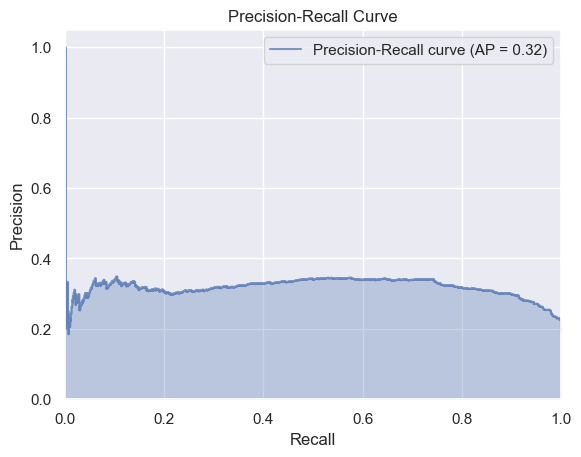

In [44]:
precision, recall, _ = precision_recall_curve(y_test_simulated, prediction_scores)
average_precision = average_precision_score(y_test_simulated, prediction_scores)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.7, label='Precision-Recall curve (AP = %0.2f)' % average_precision)
plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
